In [48]:
import os
import torch
from torch import nn
from d2l import torch as d2l

# 1.1读取数据集

In [49]:
d2l.DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [50]:
data_dir

'..\\data\\aclImdb'

In [60]:
# 1表示积极， 0表示消极
def read_imdb(data_dir, is_train):
    """读取IMDb评论数据集文本序列和标签"""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',label)
        for file in os.listdir(folder_name):#os.listdir返回指定的文件夹包含的文件或文件夹的名字的列表
            with open(os.path.join(folder_name, file),'rb') as f:
                review = f.read().decode('utf-8').replace('\n','')# 从文件当前位置起读取size个字节，若无参数size，则表示读取至文件结束为止
                data.append(review) #一行表示一个样本数据及标签
                labels.append(1 if label=='pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('训练集数目：',len(train_data[0]))
for x,y in zip(train_data[0][:3],train_data[1][:3]):
    print("标签",y,"review",x[0:50])

训练集数目： 25000
标签 1 review Bromwell High is a cartoon comedy. It ran at the s
标签 1 review Homelessness (or Houselessness as George Carlin st
标签 1 review Brilliant over-acting by Lesley Ann Warren. Best d


# 1.2预处理数据集

In [7]:
def tokenize(lines, token):
    '''将文本行拆分为单次或字符词元'''
    if token == 'word':
        return [line.split() for line in lines]
    if token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR：未知词元类型：'+ token)
        
train_tokens = tokenize(train_data[0],token='word')
print(f'训练集大小：{len(train_tokens)}')

训练集大小：25000


In [8]:
import collections
class Vocab:
    '''建立对应数据集的词汇表'''
    def __init__(self,tokens=None, min_freq=0 ,reversed_token=None):
        if tokens is None:
            tokens = []
        if reversed_token is None:
            reversed_token = []
        #按照出现频率排序    
        counter = corpus_freq(tokens)
        self._token_freq = sorted(counter.items(), key=lambda x:x[1],reverse=True)
        #未知词源索引为0
        self.idx_to_token = ['<unk>'] + reversed_token
        self.token_to_idx = {token:idx 
                             for idx,token in enumerate(self.idx_to_token)}
        for token,freq in self._token_freq:
            if freq < min_freq:
                break
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1
            
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):#传入一个样本对应的token列表
        if not isinstance(tokens, (list,tuple)):
            return self.token_to_idx.get(tokens, self.unk)#字典中不存在的tokens值赋值为0
        return [self.__getitem__(token) for token in tokens]
    
    def to_token(self,indices):
        if not isinstance(indices, (list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[indice] for indice in indices]
    
    @property
    def unk(self):
        return 0
    
    @property
    def token_freq(self):
        return self._token_freq
        
def corpus_freq(tokens):
    '''统计词元的频率'''
    # 这里的tokens是1D列表或2D列表
    if isinstance(tokens[0], list) or len(tokens)==0:
        token = [token for lines in tokens for token in lines]
    return collections.Counter(token)

In [9]:
vocab = Vocab(train_tokens,min_freq=5)
#vocab.to_token(vocab[train_tokens[0]])
print(f'词汇表大小：{len(vocab)}')
print(f'前10个频率最高的词汇为：{vocab.token_freq[:10]}')

词汇表大小：49346
前10个频率最高的词汇为：[('the', 287032), ('a', 155096), ('and', 152664), ('of', 142972), ('to', 132568), ('is', 103229), ('in', 85580), ('I', 65973), ('that', 64560), ('this', 57199)]


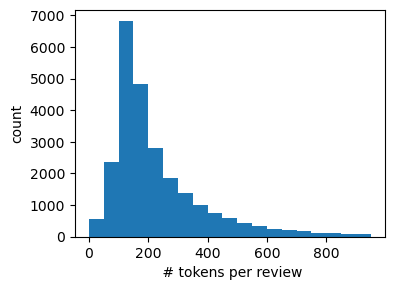

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3),dpi=100)
plt.xlabel(' # tokens per review')
plt.ylabel('count')
plt.hist([len(line) for line in train_tokens],bins = range(0,1000,50))
plt.show()

In [11]:
# 评论的长度各不相同,通过截断和填充将每个评论的长度设置为500
num_step = 500
def truncate_pad(line, num_step, padding_token):
    '''对一个样本进行裁剪和填充，保证长度为num_step'''
    if len(line) < num_step:
        line += [padding_token]*(num_step-len(line))
    elif len(line) >= num_step:
        line = line[:num_step]
    return line

train_features = torch.tensor([
    truncate_pad(vocab[line], num_step, vocab['<pad>']) 
    for line in  train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


# 1.3创建数据迭代器

In [16]:
from torch.utils.data import DataLoader,Dataset,TensorDataset
def load_array(data_arrays, batch_size,is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = TensorDataset(*data_arrays)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train)

train_iter = load_array((train_features,torch.tensor(train_data[1])),64)

for X ,y in train_iter:
    print(f'X.shape:{X.shape},\t y.shape:{y.shape}')
    break
print(f'小批量的个数数据：{len(train_iter)}')

X.shape:torch.Size([64, 500]),	 y.shape:torch.Size([64])
小批量的个数数据：391


# 1整合以上数据集处理代码

In [50]:
# 大型电影评论数据集（large movie review dataset）进行情感分析
def load_data_imdb(batch_size, num_steps=500):
    # 获取文件路径
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    ############ 读取文件，获取训练数据
    train_data = read_imdb(data_dir, is_train=True)
    test_data = read_imdb(data_dir, is_train=False)
    ############ 将数据token化
    train_tokens = tokenize(train_data[0],token='word')
    test_tokens = tokenize(test_data[0],token='word')
    
    ###########构建词表vocab
    vocab = d2l.Vocab(train_tokens,min_freq=5)
    ############ 根据词表vocab将数据转化，并裁剪到固定长度
    train_features = torch.tensor([
    truncate_pad(vocab[line], num_step, vocab['<pad>']) 
    for line in  train_tokens])
    test_features = torch.tensor([
    truncate_pad(vocab[line], num_step, vocab['<pad>']) 
    for line in  test_tokens])
    
    ##########将数据拼接，整理成小批量数据
    train_iter = load_array((train_features,torch.tensor(train_data[1])),
                            batch_size=batch_size)
    #测试机不打乱顺序
    test_iter = load_array((test_features,torch.tensor(test_data[1])),
                           batch_size=batch_size,is_train=False)
    return train_iter, test_iter, vocab

batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

# 2.1 使用RNN来表示单个文本
1. 多层双向循环神经网络
2. 将初始时间步和最终时间步的隐状态（最后一层）连接起来作为文本序列的表示
3. 具有两个输出（“积极”和“消极”）的全连接层（self.decoder），将此单一文本表示转换为输出类别
4. 可变长度的文本序列将被转换为固定长度的类别

In [53]:
'''
将多余出的 键值对 行后的零散实参打包组成一个tuple传递给*args
将多余的 key=value 形式的实参打包正一个 dicrionary 传递给**kargs
1、*args是可变无键参数，tuple类型； 2、**kwargs是可变有键参数，
'''

class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters() #重置参数数据指针，以便可以使用更快的代码路径
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        #print(outputs.shape)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [54]:
embed_size, num_hiddens, num_layers = 100, 100, 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        
    if isinstance(m, nn.LSTM):
        # m._flat_weights_names为weight， bias参数
        for param in m._flat_weights_names:
            if 'weight' in param:
                # m._parameters为字典
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

# 2.2 加载预训练的词向量

In [51]:
class TokenEmbedding:
    """Glove嵌入"""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token:idx
                            for idx, token in enumerate(self.idx_to_token)}
        
    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'],[]
        data_dir = d2l.download_extract(embedding_name)
        # GloVe网站：https://nlp.stanford.edu/projects/glove/
        # fastText网站：https://fasttext.cc/
        with open(os.path.join(data_dir,'vec.txt'), 'r',encoding='utf-8') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token ,elems = elems[0], [float(elem) for elem in elems[1:]]
                # 跳过标题信息，例如fastText中的首行
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
            
        idx_to_vec = [[0]*len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)
    
    # 返回对应token的vecs向量
    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token,self.unknown_idx)
                  for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs
    
    def __len__(self):
        return len(self.idx_to_token)
    
glove_embedding = TokenEmbedding('glove.6b.100d')    

# 取出了token对应的vec
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [55]:
# 用预训练的词向量来表示评论中的词元，并且在训练期间不要更新这些向量
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad_=False

# 3. 训练和评估模型

In [61]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

def train_batch(net,X,y,loss, trainer,device):
    if isinstance(X,list):
        X = [x.to(device) for x in X]
    else:
        X = X.to(device)
    y = y.to(device)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = (pred.argmax(1)==y).sum()
    return train_loss_sum, train_acc_sum

def train(net, train_iter, test_iter, loss, trainer, num_epochs,device):
    timer, num_batches = d2l.Timer(),len(train_iter)
    animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0,1],
                           legend=['train loss','train acc', 'test acc'])
    net = net.to(device)
#     num_batches = len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l,acc = train_batch(net,features, labels, loss,trainer,device)
            metric.add(l,acc,labels.shape[0],labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        net.eval()
        with torch.no_grad():
            test_acc = 0
            test_num = 0
            for X, y in test_iter:
                if isinstance(X,list):
                    X = [x.to(device) for x in X]
                else:
                    X = X.to(device)
                y = y.to(device)
                pred = net(X)
                test_acc += (pred.argmax(1)==y).sum()
                test_num += y.numel()
            animator.add(epoch + 1, (None, None, test_acc/test_num))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc/test_num:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(device)}')
    

loss 0.034, train acc 0.991, test acc 0.829
512.8 examples/sec on cuda


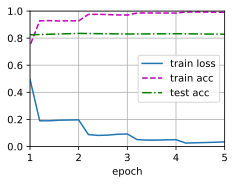

In [62]:
train(net, train_iter, test_iter, loss, trainer, num_epochs,device)
#train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,device)

## 预测

In [66]:
def predict_sentiment(net, vocab, sequence):
    sequence = torch.tensor(vocab[sequence.split(' ')],device = device)
    label = torch.argmax(net(sequence.reshape(1,-1)),dim=1) #输入句子长度不需要裁剪
    return 'position' if label==1 else 'negative'

In [67]:
sequence = "this movie is so great"
predict_sentiment(net,vocab,sequence)

'position'

In [68]:
sequence = "the weather is so bad, making people annoyed"
predict_sentiment(net,vocab,sequence)

'negative'

# 2. 卷积神经网络预测分类

In [15]:

def corr1d(X,K):
    W = K.shape[0]
    y = torch.zeros(X.size(0) - W + 1)
    for i in range(y.size(0)):
        y[i] = (X[i:i+W]*K).sum()
    return y
    
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

In [28]:
def corr1d_multi_in(X,K):
    
    # path1
#     W = K.size(1)
#     c = K.size(0)
#     Y = torch.zeros(c,X.size(1)-W+1)
#     for i in range(c):
#         for j in range(Y.size(1)):
#             Y[i,j] = (X[i,j:j+W]*K[i,:]).sum()
#     return torch.sum(Y,dim=0)
    # path2
    return sum([corr1d(x,k) for x, k in zip(X,K)])

    
X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

## textCNN

In [46]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes,
                nums_channels, **kwargs):
        super(TextCNN,self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 这个嵌入层不需要训练
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels),2)
        # 最大时间汇聚层没有参数，因此可以共享此实例
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # 创建多个一维卷积层
        self.convs = nn.ModuleList()
        for c,k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2*embed_size,c,k))# input_ch, output_ch, kernel_size
            
    def forward(self, inputs):
        # 沿着向量维度将两个嵌入层连结起来，
        # 每个嵌入层的输出形状都是（批量大小，词元数量，词元向量维度）连结起来
        embeddings = torch.cat((self.embedding(inputs),
                              self.constant_embedding(inputs)),dim=2)
        # 根据一维卷积层的输入格式，重新排列张量，以便通道作为第2维
        embeddings = embeddings.permute(0,2,1)
        # 每个一维卷积层在最大时间汇聚层合并后，获得的张量形状是（批量大小，通道数，1）
        # 删除最后一个维度并沿通道维度连结
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))),dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [47]:
# 创建一个textCNN实例。它有3个卷积层，卷积核宽度分别为3、4和5，均有100个输出通道。
embed_size, kernel_sizes, nums_channels = 100, [3,4,5],[100,100,100]
devices = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = TextCNN(len(vocab), embed_size, kernel_sizes,nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)
        
net.apply(init_weights)

NameError: name 'vocab' is not defined

In [44]:
2**31

2147483648